In [1]:
!pip install gymnasium

In [2]:
import numpy as np
import gymnasium as gym
import os
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
from IPython.display import Image
from matplotlib import animation

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Initialize the environment

In [4]:
# Initialize the environment
env = gym.make('LunarLander-v3') #,render_mode="human"

state_space = env.observation_space.shape[0]
print('State Space:', state_space)
action_space = env.action_space.n
print('Action Space:', action_space)

State Space: 8
Action Space: 4


c:\Users\ADMIN\anaconda3\envs\gymenv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### Policy

In [5]:
# Policy Network
class Policy(nn.Module):
    def __init__(self , s_size , a_size , h_size ):
        super (Policy , self ).__init__ ()
        self.fc1 = nn.Linear( s_size , h_size )
        self.fc2 = nn.Linear( h_size , h_size * 2)
        self.fc3 = nn.Linear( h_size * 2, a_size )
    def forward(self , x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim =1)
    def act(self, state ):
        state = torch.from_numpy(state).float().unsqueeze(0)  #.to(device)
        probs = self.forward(state) # .cpu()
        m = Categorical(probs)
        # Random action
        action = m.sample()
        return action.item() , m.log_prob(action)

### REINFORCE
Initialize the policy parameter $\theta$ at random. <br>
**for** each episode $\{s_1, a_1, r_2, s_2, a_2, \dots, s_T\} $ **do** <br>
&nbsp; &nbsp; &nbsp; &nbsp;     **for** $t=1, 2, … , T $ **do** <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Calculate the Return $G_t$ <br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Update policy parameters $\theta \leftarrow \theta + \alpha \gamma^t G_t \nabla_\theta \log \pi_\theta(a_t \vert s_t)$ <br>
&nbsp; &nbsp; &nbsp; &nbsp; **end for** <br>
**end for**

Visually Explained: https://towardsdatascience.com/reinforcement-learning-explained-visually-part-6-policy-gradients-step-by-step-f9f448e73754

In [ ]:
# Training Function
def reinforce(
        policy ,
        optimizer ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every
        ):
    # scores_deque = deque(maxlen =100)
    scores = []

    # Each Episode
    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]

        # t=1, 2, … , T (compute log(policy(a_t|s_t)))
        for t in range(max_steps):
            action , log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state , reward , done , _ , _ = env.step(action)
            rewards.append(reward)
            if done :
                break
        # scores_deque.append(sum( rewards ))
        scores.append(sum(rewards))

        returns = deque(maxlen = max_steps)
        n_steps = len(rewards)

        # List of discounted Returns (compute gamma^t*G_t)
        for t in range(n_steps)[:: -1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma*disc_return_t + rewards[t])

        # Total loss (disc_return = gamma^t*G_t; log_prob = log(policy(a_t|s_t)))
        policy_loss = []
        for log_prob , disc_return in zip( saved_log_probs , returns ):
            policy_loss.append(-log_prob * disc_return )
        policy_loss = torch.cat( policy_loss ).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        print(" Episode {}, Reward : {}".format( i_episode ,sum(rewards)))

    return scores


In [ ]:
# Hyperparameter
h_size = 128
lr = 0.001
n_training_episodes = 1500
max_steps = 1000
gamma = 0.99

In [ ]:
policy = Policy (
        s_size = state_space ,
        a_size = action_space ,
        h_size = h_size ,
        ) #.to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)

In [ ]:
scores = reinforce (
        policy ,
        optimizer ,
        n_training_episodes ,
        max_steps ,
        gamma ,
        print_every = 100)
# ============== LƯU MODEL SAU KHI TRAIN ==============
# Lưu model weights
torch.save(policy.state_dict(), 'lunarlander_trained.pth')
print(f"\nModel saved to 'lunarlander_trained.pth'")

# Lưu cả model (bao gồm architecture)
torch.save(policy, 'lunarlander_model_full.pth')

import pickle
with open('training_scores.pkl', 'wb') as f:
    pickle.dump(scores, f)

env.close()


print(f"\nTraining completed!")
print(f"Final episode reward: {scores[-1]:.1f}")
print(f"Average last 100 rewards: {np.mean(scores[-100:]):.1f}")

In [ ]:

env.close()

# 2. Tạo environment mới với render
env_render = gym.make('LunarLander-v3', render_mode='human')

# 3. Dùng policy đã train để render
print("\n Now rendering trained agent...")

# Chuyển policy sang eval mode
policy.eval()

# Render một vài episodes
for episode in range(3):
    state, _ = env_render.reset()
    total_reward = 0
    done = False
    
    while not done:
        with torch.no_grad():
            action, _ = policy.act(state)
        
        state, reward, terminated, truncated, _ = env_render.step(action)
        total_reward += reward
        done = terminated or truncated
    
    print(f"Rendered Episode {episode+1}: Reward = {total_reward:.1f}")

env_render.close()
print("Rendering completed!")

In [ ]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE on LunarLander')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from torch.distributions import Categorical

# Định nghĩa lại Policy class (phải giống y hệt)
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size * 2)
        self.fc3 = nn.Linear(h_size * 2, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

#  load  run
def load_and_run(model_path='lunarlander_trained.pth', num_episodes=3, render=True):
    # environment
    render_mode = "human" if render else None
    env = gym.make('LunarLander-v3', render_mode=render_mode)
    
    # LunarLander parameters
    state_size = env.observation_space.shape[0]  # 8
    action_size = env.action_space.n             # 4
    hidden_size = 128  
    
    print("=" * 60)
    print(f"Loading model from: {model_path}")
    print(f"State size: {state_size}, Action size: {action_size}")
    print(f"Hidden size: {hidden_size}")
    print("=" * 60)
    
    # Tạo model
    policy = Policy(state_size, action_size, hidden_size)
    
    # Load model
    try:
        # Thử load state_dict trước
        policy.load_state_dict(torch.load(model_path, weights_only=True))
        print(" Loaded model weights (state_dict)")
    except Exception as e:
        print(f" Error loading state_dict: {e}")
        print("Trying to load full model with safe_globals...")
        try:
            # Nếu là full model, dùng safe_globals
            with torch.serialization.safe_globals([Policy]):
                policy = torch.load(model_path, weights_only=False)
            print("Loaded full model")
        except Exception as e2:
            print(f"Error loading full model: {e2}")
            env.close()
            return None
    
    policy.eval()  # Chuyển sang evaluation mode
    
    # Statistics
    all_rewards = []
    
    # Chạy episodes
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0
        
        while not done:
            # Lấy action từ policy
            with torch.no_grad():
                action, _ = policy.act(state)
            
            # Thực hiện action
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            step_count += 1
        
        all_rewards.append(total_reward)
        
        print(f"Episode {episode+1}: "
              f"Reward = {total_reward:7.1f}, ")
    
    env.close()
    
    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print(f"Average reward: {np.mean(all_rewards):.1f} ± {np.std(all_rewards):.1f}")
    print(f"Best episode: {np.max(all_rewards):.1f}")
    print(f"Success rate (≥200): {sum(r >= 200 for r in all_rewards)/len(all_rewards)*100:.0f}%")
    print("=" * 60)
    
    return policy

# Main execution
if __name__ == "__main__":
    print("LUNAR LANDER - MODEL RENDERING")
    print("-" * 60)
    
    # Thử load từ state_dict trước
    try:
        policy = load_and_run('lunarlander_trained.pth', num_episodes=3, render=True)
        if policy:
            print("\n Successfully rendered using state_dict!")
    except Exception as e:
        print(f"\n Error with state_dict: {e}")
        print("Trying full model...")
        try:
            policy = load_and_run('lunarlander_model_full.pth', num_episodes=3, render=True)
            if policy:
                print("\n Successfully rendered using full model!")
        except Exception as e2:
            print(f"\n All attempts failed: {e2}")

Checking for existing model files...
✅ Found: lunarlander_trained.pth


CONTINUE TRAINING FROM PRE-TRAINED MODEL
Environment: LunarLander-v3
State size: 8, Action size: 4
Hidden size: 128, Learning rate: 0.001
Additional episodes: 10
----------------------------------------------------------------------
✅ Loaded pre-trained model from lunarlander_trained.pth

STARTING ADDITIONAL TRAINING

SAVING UPDATED MODEL
✅ Model saved to 'lunarlander_continued.pth'
✅ Full model saved to 'lunarlander_continued_full.pth'
✅ Checkpoint saved to 'training_checkpoint.pth'
✅ Training scores saved

TRAINING SUMMARY
Total episodes trained: 10
Final episode reward: 12.9
Maximum reward achieved: 167.4
Minimum reward achieved: 12.9


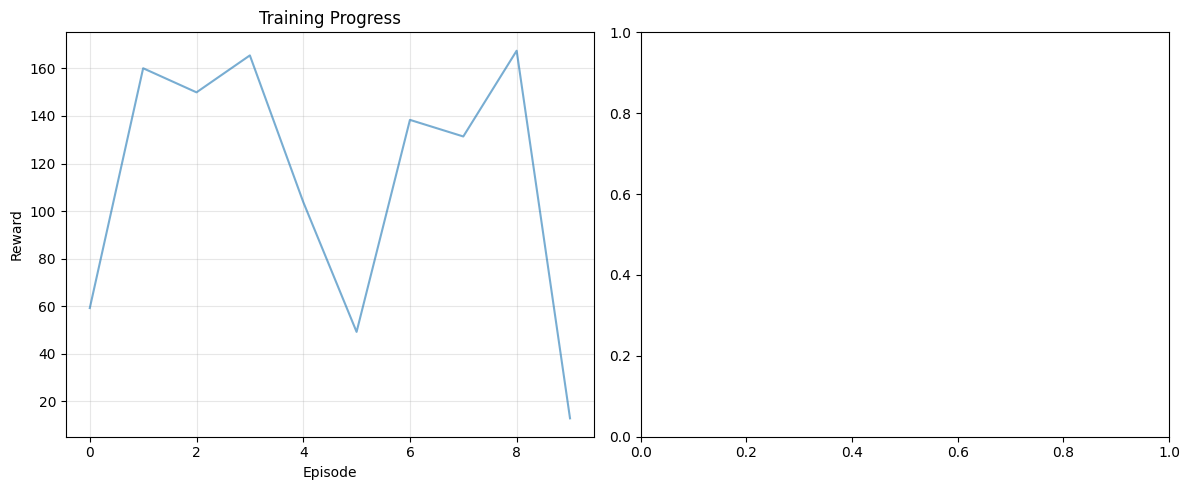


✅ Continue training completed!
Use 'policy' variable to render or test the model
Model files saved:
  - lunarlander_continued.pth (weights)
  - lunarlander_continued_full.pth (full model)
  - training_checkpoint.pth (checkpoint)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import numpy as np
from torch.distributions import Categorical
from collections import deque
import pickle

# 1. Định nghĩa Policy class (phải giống y hệt)
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size * 2)
        self.fc3 = nn.Linear(h_size * 2, a_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

# 2. Hàm training (giữ nguyên)
def reinforce(
        policy,
        optimizer,
        n_training_episodes,
        max_steps,
        gamma,
        print_every
        ):
    scores = []

    # Each Episode
    for i_episode in range(1, n_training_episodes + 1):
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]

        # t=1, 2, … , T (compute log(policy(a_t|s_t)))
        for t in range(max_steps):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # scores_deque.append(sum( rewards ))
        scores.append(sum(rewards))

        returns = deque(maxlen = max_steps)
        n_steps = len(rewards)

        # List of discounted Returns (compute gamma^t*G_t)
        for t in range(n_steps)[:: -1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma*disc_return_t + rewards[t])

        # Total loss (disc_return = gamma^t*G_t; log_prob = log(policy(a_t|s_t)))
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            avg_reward = np.mean(scores[-print_every:]) if len(scores) >= print_every else np.mean(scores)
            print(f"Episode {i_episode:4d}, Current Reward: {sum(rewards):6.1f}, Avg({print_every}): {avg_reward:6.1f}")

    return scores

# 3. Load model đã train và tiếp tục training
def continue_training(
        model_path='lunarlander_trained.pth',
        checkpoint_path=None,
        additional_episodes=500,
        save_checkpoints=True
    ):
    
    print("=" * 70)
    print("CONTINUE TRAINING FROM PRE-TRAINED MODEL")
    print("=" * 70)
    
    # Tạo environment
    global env
    env = gym.make('LunarLander-v3')
    
    # Hyperparameters (phải giống với training ban đầu)
    state_space = env.observation_space.shape[0]  # 8
    action_space = env.action_space.n             # 4
    h_size = 128
    lr = 0.001
    max_steps = 1000
    gamma = 0.99
    print_every = 100
    
    print(f"Environment: LunarLander-v3")
    print(f"State size: {state_space}, Action size: {action_space}")
    print(f"Hidden size: {h_size}, Learning rate: {lr}")
    print(f"Additional episodes: {additional_episodes}")
    print("-" * 70)
    
    # Khởi tạo policy
    policy = Policy(
        s_size=state_space,
        a_size=action_space,
        h_size=h_size,
    )
    
    # Khởi tạo optimizer
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    # Load model đã train
    try:
        # Thử load từ checkpoint (nếu có)
        if checkpoint_path and os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            policy.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_episode = checkpoint.get('episode', 0) + 1
            previous_scores = checkpoint.get('scores', [])
            print(f"✅ Loaded checkpoint from episode {start_episode-1}")
            print(f"   Previous average reward: {np.mean(previous_scores[-100:]):.1f}")
        else:
            # Load từ model weights
            policy.load_state_dict(torch.load(model_path, weights_only=True))
            start_episode = 0
            previous_scores = []
            print(f"✅ Loaded pre-trained model from {model_path}")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("Starting training from scratch...")
        start_episode = 0
        previous_scores = []
    
    # Training tiếp
    print("\n" + "=" * 70)
    print("STARTING ADDITIONAL TRAINING")
    print("=" * 70)
    
    scores = reinforce(
        policy,
        optimizer,
        n_training_episodes=additional_episodes,
        max_steps=max_steps,
        gamma=gamma,
        print_every=print_every
    )
    
    # Kết hợp scores
    all_scores = previous_scores + scores
    
    # Lưu model sau khi train tiếp
    print("\n" + "=" * 70)
    print("SAVING UPDATED MODEL")
    print("=" * 70)
    
    # Lưu model weights
    torch.save(policy.state_dict(), 'lunarlander_continued.pth')
    print(f"✅ Model saved to 'lunarlander_continued.pth'")
    
    # Lưu full model
    torch.save(policy, 'lunarlander_continued_full.pth')
    print(f"✅ Full model saved to 'lunarlander_continued_full.pth'")
    
    # Lưu checkpoint
    checkpoint = {
        'model_state_dict': policy.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scores': all_scores,
        'episode': start_episode + additional_episodes,
        'total_episodes': start_episode + additional_episodes
    }
    torch.save(checkpoint, 'training_checkpoint.pth')
    print(f"✅ Checkpoint saved to 'training_checkpoint.pth'")
    
    # Lưu scores
    with open('continued_scores.pkl', 'wb') as f:
        pickle.dump(all_scores, f)
    print(f"✅ Training scores saved")
    
    # Đóng environment
    env.close()
    
    # Hiển thị kết quả
    print("\n" + "=" * 70)
    print("TRAINING SUMMARY")
    print("=" * 70)
    if len(all_scores) > 0:
        print(f"Total episodes trained: {len(all_scores)}")
        print(f"Final episode reward: {all_scores[-1]:.1f}")
        if len(all_scores) >= 100:
            print(f"Average last 100 rewards: {np.mean(all_scores[-100:]):.1f}")
            print(f"Best 100-episode average: {max([np.mean(all_scores[i:i+100]) for i in range(len(all_scores)-99)]) if len(all_scores) >= 100 else np.mean(all_scores):.1f}")
        print(f"Maximum reward achieved: {np.max(all_scores):.1f}")
        print(f"Minimum reward achieved: {np.min(all_scores):.1f}")
    
    return policy, all_scores

# 4. Chạy continue training
import os

# Kiểm tra files tồn tại
print("Checking for existing model files...")
if os.path.exists('lunarlander_trained.pth'):
    print("✅ Found: lunarlander_trained.pth")
    model_to_load = 'lunarlander_trained.pth'
elif os.path.exists('lunarlander_model_full.pth'):
    print("✅ Found: lunarlander_model_full.pth")
    model_to_load = 'lunarlander_model_full.pth'
else:
    print("❌ No pre-trained model found. Starting from scratch.")
    model_to_load = None

# Chạy tiếp training
print("\n")
policy, scores = continue_training(
    model_path=model_to_load,
    additional_episodes=10,  # Train thêm 500 episodes
    save_checkpoints=True,
)

# 5. Visualize training progress
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot scores
plt.subplot(1, 2, 1)
plt.plot(scores, alpha=0.6)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.grid(True, alpha=0.3)

# Plot moving average
plt.subplot(1, 2, 2)
if len(scores) >= 100:
    window = 100
    moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(scores)), moving_avg, 'r-', linewidth=2)
    plt.axhline(y=200, color='g', linestyle='--', label='Solved (200)')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average (100 episodes)')
    plt.title('Performance Trend')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Continue training completed!")
print(f"Use 'policy' variable to render or test the model")
print(f"Model files saved:")
print(f"  - lunarlander_continued.pth (weights)")
print(f"  - lunarlander_continued_full.pth (full model)")
print(f"  - training_checkpoint.pth (checkpoint)")

All preserves belong to: https://github.com/hungledut/deep-reinforcement-learning-for-gym-environments/tree/master/lunarlander